In [1]:
import pandas as pd
import numpy as np
import tqdm
import gc
import matplotlib.pyplot as plt
import talib as ta
import datetime as dt
import statsmodels.api as sm
pd.set_option('display.max_rows', 16)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [3]:
START = '20070101'
END = '20251231'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']
# ST
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

In [5]:
st_df

secID  tradeDate STflg
0       000001.XSHE 2007-01-04     S
1       000001.XSHE 2007-01-05     S
2       000001.XSHE 2007-01-08     S
3       000001.XSHE 2007-01-09     S
4       000001.XSHE 2007-01-10     S
5       000001.XSHE 2007-01-11     S
6       000001.XSHE 2007-01-12     S
7       000001.XSHE 2007-01-15     S
...             ...        ...   ...
586313  688555.XSHG 2023-05-29   *ST
586314  688555.XSHG 2023-05-30   *ST
586315  688555.XSHG 2023-05-31   *ST
586316  688555.XSHG 2023-06-01   *ST
586317  688555.XSHG 2023-06-02   *ST
586318  688555.XSHG 2023-06-05   *ST
586319  688555.XSHG 2023-06-06   *ST
586320  688555.XSHG 2023-06-07   *ST

[586321 rows x 3 columns]

In [ ]:
# %%time
# # About 8 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y%m%d').year
# end_ = dt.datetime.strptime(START, '%Y%m%d').year+3
# field = ["secID","tradeDate",'preClosePrice',"closePrice",'openPrice','highestPrice','lowestPrice',"negMarketValue","turnoverValue",'turnoverVol']
# while begin_ <= 2025:
#     if begin_ == 2025:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [9]:
# %%time
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   'preClosePrice',"closePrice",
#                                                   'openPrice','highestPrice','lowestPrice',
#                                                   "negMarketValue",
#                                                   "turnoverValue",'turnoverVol'],pandas="1")
# stk_df.to_pickle('./data/stk_df.pkl')
# # Takes about 6 mins

CPU times: user 19.5 s, sys: 2.54 s, total: 22.1 s
Wall time: 4min 10s


In [6]:
stk_dict = {}
field = ["secID","tradeDate",'preClosePrice',"closePrice",'openPrice','highestPrice','lowestPrice',"negMarketValue","turnoverValue",'turnoverVol']
stk_dict[2007] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
                                                         beginDate='20070101',
                                                         endDate='20101231',
                                                         field=field,pandas="1")

stk_dict[2011] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
                                                         beginDate='20110101',
                                                         endDate='20141231',
                                                         field=field,pandas="1")

stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)

del stk_dict

stk_dict = {}
field = ["secID","tradeDate",'preClosePrice',"closePrice",'openPrice','highestPrice','lowestPrice',"negMarketValue","turnoverValue",'turnoverVol']
stk_dict[2015] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
                                                         beginDate='20150101',
                                                         endDate='20181231',
                                                         field=field,pandas="1")

stk_dict[2019] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
                                                         beginDate='20190101',
                                                         endDate='20221231',
                                                         field=field,pandas="1")

stk_df2 = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)

stk_df = pd.DataFrame(np.vstack([stk_df, stk_df2]),columns=field)

del stk_dict

In [8]:
stk_df.to_pickle('./data/stk_df2022.pkl')

In [9]:
del stk_df

In [14]:
stk_dict = {}
stk_dict[2023] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
                                                         beginDate='20230101',
                                                         endDate='20250428',
                                                         field=field,pandas="1")

In [11]:
stk_dict[2023]

secID   tradeDate  preClosePrice  closePrice  openPrice  \
0        000001.XSHE  2023-01-03       1721.635    1801.437   1726.868   
1        000001.XSHE  2023-01-04       1801.437    1873.390   1793.588   
2        000001.XSHE  2023-01-05       1873.390    1894.322   1883.856   
3        000001.XSHE  2023-01-06       1894.322    1912.637   1896.938   
4        000001.XSHE  2023-01-09       1912.637    1936.185   1929.644   
5        000001.XSHE  2023-01-10       1936.185    1889.089   1930.953   
6        000001.XSHE  2023-01-11       1889.089    1919.178   1890.397   
7        000001.XSHE  2023-01-12       1919.178    1919.178   1932.261   
...              ...         ...            ...         ...        ...   
2838392  689009.XSHG  2025-04-17         55.186      55.136     54.934   
2838393  689009.XSHG  2025-04-18         55.136      55.901     55.085   
2838394  689009.XSHG  2025-04-21         55.901      56.193     55.992   
2838395  689009.XSHG  2025-04-22         56.193      58.791     56.193   
2838396  689009.XSHG  2025-04-23         58.791      60.221     59.808   
2838397  689009.XSHG  2025-04-24         60.221      59.969     59.798   
2838398  689009.XSHG  2025-04-25         59.969      61.853     59.859   
2838399  689009.XSHG  2025-04-28         61.853      61.893     62.034   

         highestPrice  lowestPrice  negMarketValue  turnoverValue  turnoverVol  
0            1811.903     1707.245    2.672144e+11   2.971547e+09      2645315  
1            1886.473     1783.122    2.778874e+11   3.110729e+09      2639956  
2            1928.336     1879.931    2.809923e+11   2.417272e+09      2007893  
3            1925.720     1894.322    2.837091e+11   1.747915e+09      1441630  
4            1946.651     1899.555    2.872021e+11   1.561368e+09      1275150  
5            1947.960     1882.548    2.802161e+11   1.851094e+09      1530460  
6            1933.569     1882.548    2.846794e+11   1.217451e+09      1001359  
7            1932.261     1900.863    2.846794e+11   9.143677e+08       754359  
...               ...          ...             ...            ...          ...  
2838392        55.951       54.401    3.009985e+10   2.952241e+08      5374799  
2838393        56.253       54.884    3.051768e+10   2.155795e+08      3887490  
2838394        57.351       55.418    3.067711e+10   2.905309e+08      5175243  
2838395        59.698       56.042    3.209551e+10   4.483687e+08      7756188  
2838396        61.631       59.395    3.287619e+10   4.083429e+08      6790076  
2838397        60.624       59.073    3.273874e+10   2.893707e+08      4865752  
2838398        62.699       59.859    3.376681e+10   3.832608e+08      6234830  
2838399        62.427       61.158    3.378880e+10   2.285527e+08      3725384  

[2838400 rows x 10 columns]

In [13]:
stk_df = pd.DataFrame(np.vstack([pd.read_pickle('./data/stk_df2022.pkl'), stk_dict[2023]]),columns=field)

In [16]:
del stk_dict

In [17]:
gc.collect()

110

In [18]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            __:  5.1 GiB
                        stk_df:  5.1 GiB
                           _15:  5.1 GiB
                            _7:  4.0 GiB
                       stk_df2:  2.6 GiB
                           _11: 538.7 MiB
                         st_df: 76.0 MiB
                            _5: 76.0 MiB
                      stk_info:  3.7 MiB
                        stk_id: 404.2 KiB


In [19]:
del __

In [20]:
del _15, _7, stk_df2, 

In [21]:
gc.collect()

73

In [27]:
import sys
from IPython import get_ipython

ipython = get_ipython()

# 先复制一份静态的变量字典
all_vars = dict(ipython.user_ns)

sizes = []
for name, var in all_vars.items():
    try:
        size = sys.getsizeof(var)
        sizes.append((size, name))
    except:
        pass

# 按大小排序输出
for size, name in sorted(sizes, reverse=True):
    if size > 10 * 1024 * 1024:
        print(f"{name}: {size / 1024 / 1024:.2f} MB")

stk_df: 5212.65 MB
_22: 5212.65 MB
_: 5212.65 MB
_11: 538.68 MB
st_df: 75.99 MB
_5: 75.99 MB


In [28]:
del _22, _

In [29]:
del _11

In [31]:
gc.collect()

22

In [23]:
# stk_df.to_pickle('./data/stk_df.pkl')

In [8]:
# stk_df = pd.read_pickle('./data/stk_df.pkl')

In [32]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13842636 entries, 0 to 13842635
Data columns (total 10 columns):
secID             object
tradeDate         object
preClosePrice     object
closePrice        object
openPrice         object
highestPrice      object
lowestPrice       object
negMarketValue    object
turnoverValue     object
turnoverVol       object
dtypes: object(10)
memory usage: 1.0+ GB


In [33]:
for col in stk_df.columns.drop(['secID','tradeDate']).tolist():
    stk_df[col] = pd.to_numeric(stk_df[col])

In [34]:
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)

(13842636, 10)
(13256818, 10)


In [35]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13256818 entries, 109 to 13842635
Data columns (total 10 columns):
secID             object
tradeDate         datetime64[ns]
preClosePrice     float64
closePrice        float64
openPrice         float64
highestPrice      float64
lowestPrice       float64
negMarketValue    float64
turnoverValue     float64
turnoverVol       int64
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 1.1+ GB


不填充停牌值比较合理，因为技术分析只看量价，直接计算量价关系较为合适

In [36]:
# 随机选取1000支股票以缓解内存压力
random_stkid = np.random.choice(stk_df['secID'].unique(),1000)
stk_df = stk_df[stk_df['secID'].isin(random_stkid)].copy()

In [37]:
stk_df.drop(stk_df.loc[stk_df['openPrice']==0].index,inplace=True)

In [38]:
stk_df['open_ret'] = stk_df.groupby('secID')['openPrice'].apply(lambda x: x / x.shift() - 1)
stk_df['close_ret'] = stk_df['closePrice']/stk_df['preClosePrice'] - 1

In [39]:
def rule_return(df, demean=True, open_ret=True):
    """
    df should contain these columns:
        signal: the signal generated by the rule
        close_ret: return calculated by close price
        open_ret: return calculated by open price
    close_ret_demean is demeaned return of close_ret, i.e. close_ret - close_ret.mean.
    open_ret_demean is similarly defined. The use of demeaned return series is to adjust the
    bias created by bullish or bearish markets.
    """
    df['close_ret_demean'] = df['close_ret'] - df['close_ret'].mean()
    df['open_ret_demean'] = df['open_ret'] - df['open_ret'].mean()
    df['position_close'] = df['signal']
    df['position_open'] = df['signal'].shift()
    df['position_close_ret'] = df['position_close'].shift() * df['close_ret']
    df['position_open_ret'] = df['position_open'].shift() * df['open_ret']
    df['position_close_ret_demean'] = df['position_close'].shift() * df['close_ret_demean']
    df['position_open_ret_demean'] = df['position_open'].shift() * df['open_ret_demean']
    df['close_cumret'] = (df['position_close_ret']+1).cumprod()
    df['open_cumret'] = (df['position_open_ret']+1).cumprod()
    if open_ret:
        if demean:
            return pd.DataFrame({'position_open_ret_demean':df['position_open_ret_demean'].values, 
                                 'open_cumret':df['open_cumret'].values})
        else:
            return pd.DataFrame({'position_open_ret':df['position_open_ret'].values, 
                                 'open_cumret':df['open_cumret'].values})
    else:
        if demean:
            return pd.DataFrame({'position_close_ret_demean':df['position_close_ret_demean'].values, 
                                 'close_cumret':df['close_cumret'].values})
        else:
            return pd.DataFrame({'position_close_ret':df['position_close_ret'].values, 
                                 'close_cumret':df['close_cumret'].values})

In [40]:
gc.collect()

29

# A bunch of TA signals

In [41]:
# EMA
stk_df['EMA'] = stk_df.groupby('secID')['closePrice'].apply(ta.EMA, 20)
stk_df['EM_signal'] = np.where(stk_df['closePrice']>stk_df['EMA'],1,np.nan)
stk_df.loc[stk_df['closePrice']<=stk_df['EMA'],'EM_signal'] = 0
stk_df['EM_signal'] = stk_df.groupby('secID')['EM_signal'].fillna(method='ffill')

In [42]:
stk_df['EM_signal'].value_counts()

0.0    1148705
1.0    1074230
Name: EM_signal, dtype: int64

In [43]:
# MACD
stk_df['MACD'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[0])
stk_df['MACD_rawsignal'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[1])
stk_df['MACD_signal'] = np.where(stk_df['MACD']>stk_df['MACD_rawsignal'],1,np.nan)
stk_df.loc[stk_df['MACD']<=stk_df['MACD_rawsignal'],'MACD_signal'] = 0
stk_df['MACD_signal'] = stk_df.groupby('secID')['MACD_signal'].fillna(method='ffill')

In [44]:
stk_df['MACD_signal'].value_counts()

1.0    1147711
0.0    1062447
Name: MACD_signal, dtype: int64

In [45]:
# # Example
# temp = stk_df[stk_df['secID']=='900957.XSHG'].copy()
# ta.OBV(temp['closePrice'],temp['turnoverValue'])
# stk_df.loc[9968491:]

---

OBV: https://wiki.mbalib.com/wiki/%E8%83%BD%E9%87%8F%E6%BD%AE%E6%8C%87%E6%A0%87#:~:text=OBV%E6%8C%87%E6%A0%87%E5%B0%B1%E6%98%AF%E4%BB%8E%E2%80%9C%E9%87%8F,%E7%9A%84%E5%88%86%E6%9E%90%E6%8C%87%E6%A0%87%E4%B9%8B%E4%B8%80%E3%80%82

In [46]:
# OBV
stk_df['OBV'] = stk_df.groupby('secID')[['closePrice','turnoverVol']].apply(lambda x: ta.OBV(real=x['closePrice'],volume=x['turnoverVol']).to_frame('OBV')).values
stk_df.groupby('secID')['OBV'].apply(lambda x: x/x.shift()-1)
stk_df['OBV_change'] = stk_df.groupby('secID')['OBV'].apply(lambda x: x/x.shift()-1)
buy1_OBV = (stk_df['close_ret']<0)&(stk_df['OBV_change']>0)
buy2_OBV = (stk_df['close_ret']>0)&(stk_df['OBV_change']>0)
sell1_OBV = (stk_df['close_ret']>0)&(stk_df['OBV_change']<0)
sell2_OBV = (stk_df['close_ret']<0)&(stk_df['OBV_change']<0)
stk_df['OBV_signal'] = 0
stk_df.loc[buy1_OBV | buy2_OBV,'OBV_signal']=1

In [47]:
stk_df['OBV_signal'].value_counts()

0    1135165
1    1105131
Name: OBV_signal, dtype: int64

---

AROON:
https://wiki.mbalib.com/wiki/%E9%98%BF%E9%9A%86%E6%8C%87%E6%A0%87#:~:text=%E9%98%BF%E9%9A%86%E6%8C%87%E6%A0%87%EF%BC%88Aroon%EF%BC%89%E6%98%AF,%E5%A4%9A%EF%BC%8C%E5%85%B6%E6%95%88%E5%8A%9B%E8%B6%8A%E4%BD%8E%E3%80%82

In [48]:
# AROON
N = 26
high_threshold = 70  # 强趋势
low_threshold = 30  # 弱趋势

stk_df['AROON_up'] = stk_df.groupby('secID')[['highestPrice','lowestPrice']].apply(lambda x:ta.AROON(high=x['highestPrice'],low=x['lowestPrice'])[0].to_frame('AROON_up')).values
stk_df['AROON_down'] = stk_df.groupby('secID')[['highestPrice','lowestPrice']].apply(lambda x:ta.AROON(high=x['highestPrice'],low=x['lowestPrice'])[1].to_frame('AROON_down')).values
buy_AROON = (stk_df['AROON_up']>high_threshold)&(stk_df['AROON_down']<low_threshold)
sell_AROON = (stk_df['AROON_down']>high_threshold)&(stk_df['AROON_up']<low_threshold)
stk_df['AROON_signal'] = np.where(buy_AROON,1,np.nan)
stk_df.loc[sell_AROON,'AROON_signal'] = 0
stk_df['AROON_signal'] = stk_df.groupby('secID')['AROON_signal'].fillna(method='ffill')

In [49]:
stk_df['AROON_signal'].value_counts()

0.0    1113177
1.0    1112642
Name: AROON_signal, dtype: int64

---

BOLL:
https://wiki.mbalib.com/wiki/%E5%B8%83%E6%9E%97%E7%BA%BF%E6%8C%87%E6%A0%87

In [50]:
# BOLL
stk_df['BOLL_up'] = stk_df.groupby('secID')[['closePrice']].apply(lambda x:ta.BBANDS(real=x['closePrice'])[0].to_frame('BOLL_up')).values
stk_df['BOLL_mid'] = stk_df.groupby('secID')[['closePrice']].apply(lambda x:ta.BBANDS(real=x['closePrice'])[1].to_frame('BOLL_mid')).values
stk_df['BOLL_low'] = stk_df.groupby('secID')[['closePrice']].apply(lambda x:ta.BBANDS(real=x['closePrice'])[2].to_frame('BOLL_low')).values
stk_df['BOLL_up_lag'] = stk_df.groupby('secID')['BOLL_up'].shift()
stk_df['BOLL_mid_lag'] = stk_df.groupby('secID')['BOLL_mid'].shift()
stk_df['BOLL_low_lag'] = stk_df.groupby('secID')['BOLL_low'].shift()

buy_BOLL = (stk_df['preClosePrice'] < stk_df['BOLL_up_lag'])&(stk_df['closePrice']>stk_df['BOLL_up'])
sell_BOLL = (stk_df['preClosePrice'] > stk_df['BOLL_mid_lag'])&(stk_df['closePrice']<stk_df['BOLL_mid'])
stk_df['BOLL_signal'] = np.where(buy_BOLL, 1, np.nan)
stk_df.loc[sell_BOLL,'BOLL_signal'] = 0
stk_df['BOLL_signal'] = stk_df.groupby('secID')['BOLL_signal'].fillna(method='ffill')

In [51]:
stk_df['BOLL_signal'].value_counts()

0.0    2230317
1.0        307
Name: BOLL_signal, dtype: int64

---

CCI:
https://wiki.mbalib.com/wiki/%E9%A1%BA%E5%8A%BF%E6%8C%87%E6%A0%87

In [52]:
# CCI
buy_threshold = -100  # 买入阈值
sell_threshold = 100  # 卖出阈值
stk_df['CCI'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice']].apply(lambda x:ta.CCI(high=x['highestPrice'],low=x['lowestPrice'],close=x['closePrice']).to_frame('CCI')).values

In [53]:
buy_CCI = stk_df['CCI']<buy_threshold
sell_CCI = stk_df['CCI']>sell_threshold
stk_df['CCI_signal'] = np.where(buy_CCI,1,np.nan)
stk_df.loc[sell_CCI,'CCI_signal'] = 0
stk_df['CCI_signal'] = stk_df.groupby('secID')['CCI_signal'].fillna(method='ffill')

In [54]:
stk_df['CCI_signal'].value_counts()

1.0    1113018
0.0    1112225
Name: CCI_signal, dtype: int64

---

CMO:

https://wiki.mbalib.com/wiki/%E9%92%B1%E5%BE%B7%E5%8A%A8%E9%87%8F%E6%91%86%E5%8A%A8%E6%8C%87%E6%A0%87

In [55]:
# CMO
buy_threshold = -50  # 买入阈值
sell_threshold = 50
stk_df['CMO'] = stk_df.groupby('secID')['closePrice'].apply(ta.CMO)

In [56]:
buy_CMO = stk_df['CMO'] < buy_threshold
sell_CMO = stk_df['CMO'] > sell_threshold
stk_df['CMO_signal'] = np.where(buy_CMO, 1, np.nan)
stk_df.loc[sell_CMO,'CMO_signal'] = 0
stk_df['CMO_signal'] = stk_df.groupby('secID')['CMO_signal'].fillna(method='ffill')

In [57]:
stk_df['CMO_signal'].value_counts()

0.0    1318252
1.0     861678
Name: CMO_signal, dtype: int64

In [58]:
gc.collect()

51

---

DMI:
https://qhweb.eastmoney.com/videos/10/1900511.html#:~:text=DMI%EF%BC%88Directional%20Movement%20Index%EF%BC%89%E5%8F%AB%E5%81%9A,%E4%BA%8E%E4%B8%AD%E9%95%BF%E6%9C%9F%E6%8A%80%E6%9C%AF%E5%88%86%E6%9E%90%E3%80%82

In [59]:
# DMI
stk_df['plus_DI'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice']].apply(lambda x: ta.PLUS_DI(high=x['highestPrice'], low=x['lowestPrice'], close=x['closePrice']).to_frame()).values
stk_df['minus_DI'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice']].apply(lambda x: ta.MINUS_DI(high=x['highestPrice'], low=x['lowestPrice'], close=x['closePrice']).to_frame()).values
stk_df['ADX'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice']].apply(lambda x: ta.ADX(high=x['highestPrice'], low=x['lowestPrice'], close=x['closePrice']).to_frame()).values

In [60]:
buy_threshold = 50 
sell_threshold = 20
buy_DMI = (stk_df['ADX']>buy_threshold)&(stk_df['plus_DI']>stk_df['minus_DI'])
sell_DMI = (stk_df['ADX']<sell_threshold)|(stk_df['plus_DI']<stk_df['minus_DI'])
stk_df['DMI_signal'] = np.where(buy_DMI,1,np.nan)
stk_df.loc[sell_DMI,'DMI_signal'] = 0
stk_df['DMI_signal'] = stk_df.groupby('secID')['DMI_signal'].fillna(method='ffill')

In [61]:
stk_df['DMI_signal'].value_counts()

0.0    2133868
1.0      79034
Name: DMI_signal, dtype: int64

---

MFI:
https://wiki.mbalib.com/wiki/%E8%B5%84%E9%87%91%E6%B5%81%E9%87%8F%E6%8C%87%E6%A0%87


In [62]:
# MFI
stk_df['MFI'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice','turnoverVol']].apply(lambda x:ta.MFI(high=x['highestPrice'],low=x['lowestPrice'],close=x['closePrice'],volume=x['turnoverVol']).to_frame()).values

In [63]:
buy_threshold = 20  
sell_threshold = 80 
buy_MFI = stk_df['MFI']<buy_threshold
sell_MFI = stk_df['MFI']>sell_threshold
stk_df['MFI_signal'] = np.where(buy_MFI,1,np.nan)
stk_df.loc[sell_MFI,'MFI_signal'] = 0
stk_df['MFI_signal'] = stk_df.groupby('secID')['MFI_signal'].fillna(method='ffill')

In [64]:
stk_df['MFI_signal'].value_counts()

0.0    1459658
1.0     739860
Name: MFI_signal, dtype: int64

---

RSI:

https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%B0%8D%E5%BC%B7%E5%BC%B1%E6%8C%87%E6%95%B8

In [65]:
# RSI
stk_df['RSI'] = stk_df.groupby('secID')['closePrice'].apply(ta.RSI)
buy_threshold = 30
sell_threshold = 70
buy_RSI = stk_df['RSI'] < buy_threshold
sell_RSI = stk_df['RSI'] > sell_threshold
stk_df['RSI_signal'] = np.where(buy_RSI,1,np.nan)
stk_df.loc[sell_RSI,'RSI_signal'] = 0
stk_df['RSI_signal'] = stk_df.groupby('secID')['RSI_signal'].fillna(method='ffill')

In [66]:
# %%time
# WVAD
# def wvad(df):
#     return sum((df[:,0] - df[:,1]) / (df[:,2] - df[:,3]) * df[:,4])

# stk_df.groupby('secID')[['closePrice','openPrice','highestPrice',
#                          'lowestPrice','turnoverVol']].apply(lambda x: x.rolling(24).apply(wvad,raw=False))
####### The above code is not working ##########

# temp = stk_df[stk_df['secID'].isin(np.random.choice(stk_df['secID'].unique(),10))].copy()
# def wvad(closePrice):
#     close = closePrice
#     open_ = stk_df.loc[closePrice.index, 'openPrice'].to_numpy()
#     high = stk_df.loc[closePrice.index, 'highestPrice'].to_numpy()
#     low = stk_df.loc[closePrice.index, 'lowestPrice'].to_numpy()
#     volume = stk_df.loc[closePrice.index, 'turnoverVol'].to_numpy()
#     return sum((closePrice - open_) / (high - low) * volume)
# temp2 = temp.groupby('secID')['closePrice'].rolling(24).apply(wvad, raw=False)

In [67]:
stk_df.reset_index(inplace=True, drop=True)

In [68]:
cols = ['secID','tradeDate','open_ret'] + [col for col in stk_df.columns if col[-6:]=='signal']

ret_df = stk_df[cols].copy()

ret_df['signal_date'] = ret_df['tradeDate']

ret_df[['tradeDate','open_ret']] = ret_df.groupby('secID')[['tradeDate','open_ret']].shift(-2)

ret_df.dropna(inplace=True)

ret_df.drop('MACD_rawsignal',axis=1,inplace=True)

ret_df['ret_sign'] = np.where(ret_df['open_ret']>0,1,-1)

ret_df

secID  tradeDate  open_ret  EM_signal  MACD_signal  OBV_signal  \
301      000001.XSHE 2008-09-16 -0.024845        0.0          0.0           0   
302      000001.XSHE 2008-09-17 -0.112738        0.0          0.0           0   
303      000001.XSHE 2008-09-18 -0.101938        0.0          0.0           0   
304      000001.XSHE 2008-09-19  0.169463        0.0          0.0           0   
305      000001.XSHE 2008-09-22  0.099111        0.0          0.0           1   
306      000001.XSHE 2008-09-23 -0.042287        0.0          0.0           1   
307      000001.XSHE 2008-09-24 -0.045456        0.0          0.0           1   
308      000001.XSHE 2008-09-25  0.005443        0.0          0.0           0   
...              ...        ...       ...        ...          ...         ...   
2240286  688981.XSHG 2025-04-17  0.003297        0.0          1.0           0   
2240287  688981.XSHG 2025-04-18  0.002081        1.0          1.0           1   
2240288  688981.XSHG 2025-04-21 -0.001640        1.0          1.0           0   
2240289  688981.XSHG 2025-04-22 -0.009196        1.0          1.0           0   
2240290  688981.XSHG 2025-04-23 -0.003867        0.0          1.0           0   
2240291  688981.XSHG 2025-04-24  0.000000        0.0          1.0           0   
2240292  688981.XSHG 2025-04-25 -0.011647        0.0          1.0           1   
2240293  688981.XSHG 2025-04-28 -0.007632        0.0          1.0           0   

         AROON_signal  BOLL_signal  CCI_signal  CMO_signal  DMI_signal  \
301               1.0          0.0         1.0         1.0         0.0   
302               1.0          0.0         1.0         1.0         0.0   
303               1.0          0.0         1.0         1.0         0.0   
304               1.0          0.0         1.0         1.0         0.0   
305               1.0          0.0         1.0         1.0         0.0   
306               1.0          0.0         1.0         1.0         0.0   
307               1.0          0.0         1.0         1.0         0.0   
308               1.0          0.0         1.0         1.0         0.0   
...               ...          ...         ...         ...         ...   
2240286           1.0          0.0         0.0         0.0         0.0   
2240287           1.0          0.0         0.0         0.0         0.0   
2240288           1.0          0.0         0.0         0.0         0.0   
2240289           1.0          0.0         0.0         0.0         0.0   
2240290           1.0          0.0         0.0         0.0         0.0   
2240291           1.0          0.0         0.0         0.0         0.0   
2240292           1.0          0.0         0.0         0.0         0.0   
2240293           1.0          0.0         0.0         0.0         0.0   

         MFI_signal  RSI_signal signal_date  ret_sign  
301             1.0         1.0  2008-09-11        -1  
302             1.0         1.0  2008-09-12        -1  
303             1.0         1.0  2008-09-16        -1  
304             1.0         1.0  2008-09-17         1  
305             1.0         1.0  2008-09-18         1  
306             1.0         1.0  2008-09-19        -1  
307             1.0         1.0  2008-09-22        -1  
308             1.0         1.0  2008-09-23         1  
...             ...         ...         ...       ...  
2240286         0.0         0.0  2025-04-15         1  
2240287         0.0         0.0  2025-04-16         1  
2240288         0.0         0.0  2025-04-17        -1  
2240289         0.0         0.0  2025-04-18        -1  
2240290         0.0         0.0  2025-04-21        -1  
2240291         0.0         0.0  2025-04-22        -1  
2240292         0.0         0.0  2025-04-23        -1  
2240293         0.0         0.0  2025-04-24        -1  

[2157198 rows x 15 columns]

In [69]:
ret_df.sort_values('tradeDate',inplace=True)

ret_df.reset_index(inplace=True,drop=True)

In [70]:
ret_df

secID  tradeDate  open_ret  EM_signal  MACD_signal  OBV_signal  \
0        000709.XSHE 2007-03-01  0.098590        1.0          1.0           0   
1        000027.XSHE 2007-03-01  0.050930        1.0          1.0           0   
2        002026.XSHE 2007-03-01  0.089369        1.0          1.0           0   
3        000532.XSHE 2007-03-01  0.087246        1.0          1.0           0   
4        000682.XSHE 2007-03-01  0.132123        1.0          1.0           0   
5        600612.XSHG 2007-03-01  0.056388        0.0          1.0           0   
6        000825.XSHE 2007-03-01  0.053595        0.0          0.0           0   
7        600343.XSHG 2007-03-01  0.042402        0.0          0.0           0   
...              ...        ...       ...        ...          ...         ...   
2157190  002576.XSHE 2025-04-28  0.005621        1.0          1.0           0   
2157191  002575.XSHE 2025-04-28 -0.014171        1.0          1.0           1   
2157192  603076.XSHG 2025-04-28  0.037118        0.0          1.0           0   
2157193  002555.XSHE 2025-04-28 -0.007499        1.0          1.0           0   
2157194  603080.XSHG 2025-04-28  0.008456        1.0          1.0           1   
2157195  002552.XSHE 2025-04-28 -0.030534        1.0          1.0           0   
2157196  603075.XSHG 2025-04-28 -0.001033        1.0          1.0           1   
2157197  688981.XSHG 2025-04-28 -0.007632        0.0          1.0           0   

         AROON_signal  BOLL_signal  CCI_signal  CMO_signal  DMI_signal  \
0                 0.0          0.0         0.0         0.0         0.0   
1                 0.0          0.0         0.0         0.0         0.0   
2                 0.0          0.0         0.0         0.0         0.0   
3                 0.0          0.0         0.0         0.0         1.0   
4                 0.0          0.0         0.0         0.0         0.0   
5                 0.0          0.0         0.0         0.0         0.0   
6                 0.0          0.0         0.0         0.0         0.0   
7                 0.0          0.0         0.0         0.0         1.0   
...               ...          ...         ...         ...         ...   
2157190           1.0          0.0         0.0         1.0         0.0   
2157191           0.0          0.0         1.0         0.0         0.0   
2157192           1.0          0.0         0.0         0.0         0.0   
2157193           0.0          0.0         0.0         1.0         0.0   
2157194           1.0          0.0         0.0         0.0         0.0   
2157195           0.0          0.0         0.0         1.0         0.0   
2157196           0.0          0.0         0.0         0.0         0.0   
2157197           1.0          0.0         0.0         0.0         0.0   

         MFI_signal  RSI_signal signal_date  ret_sign  
0               0.0         0.0  2007-02-27         1  
1               0.0         0.0  2007-02-27         1  
2               0.0         0.0  2007-02-27         1  
3               0.0         0.0  2007-02-27         1  
4               0.0         0.0  2007-02-27         1  
5               0.0         0.0  2007-02-27         1  
6               0.0         0.0  2007-02-27         1  
7               0.0         0.0  2007-02-27         1  
...             ...         ...         ...       ...  
2157190         0.0         1.0  2025-04-24         1  
2157191         0.0         0.0  2025-04-24        -1  
2157192         0.0         1.0  2025-04-24         1  
2157193         1.0         1.0  2025-04-24        -1  
2157194         0.0         1.0  2025-04-24         1  
2157195         1.0         1.0  2025-04-24        -1  
2157196         0.0         1.0  2025-04-24        -1  
2157197         0.0         0.0  2025-04-24        -1  

[2157198 rows x 15 columns]

# Random Forest

## Train, test split

In [71]:
ret_df['year'] = ret_df['tradeDate'].dt.year

In [72]:
time_idx = [value for (key, value) in sorted(ret_df.groupby('year').groups.items())]

In [78]:
len(time_idx)

19

In [79]:
2025-2007+1

19

In [77]:
time_idx

[Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             35936, 35937, 35938, 35939, 35940, 35941, 35942, 35943, 35944,
             35945],
            dtype='int64', length=35946),
 Int64Index([35946, 35947, 35948, 35949, 35950, 35951, 35952, 35953, 35954,
             35955,
             ...
             94583, 94584, 94585, 94586, 94587, 94588, 94589, 94590, 94591,
             94592],
            dtype='int64', length=58647),
 Int64Index([ 94593,  94594,  94595,  94596,  94597,  94598,  94599,  94600,
              94601,  94602,
             ...
             157633, 157634, 157635, 157636, 157637, 157638, 157639, 157640,
             157641, 157642],
            dtype='int64', length=63050),
 Int64Index([157643, 157644, 157645, 157646, 157647, 157648, 157649, 157650,
             157651, 157652,
             ...
             225894, 225895, 225896, 225897, 225898, 225899, 225900, 225901,
             225902, 225

In [73]:
ret_df

secID  tradeDate  open_ret  EM_signal  MACD_signal  OBV_signal  \
0        000709.XSHE 2007-03-01  0.098590        1.0          1.0           0   
1        000027.XSHE 2007-03-01  0.050930        1.0          1.0           0   
2        002026.XSHE 2007-03-01  0.089369        1.0          1.0           0   
3        000532.XSHE 2007-03-01  0.087246        1.0          1.0           0   
4        000682.XSHE 2007-03-01  0.132123        1.0          1.0           0   
5        600612.XSHG 2007-03-01  0.056388        0.0          1.0           0   
6        000825.XSHE 2007-03-01  0.053595        0.0          0.0           0   
7        600343.XSHG 2007-03-01  0.042402        0.0          0.0           0   
...              ...        ...       ...        ...          ...         ...   
2157190  002576.XSHE 2025-04-28  0.005621        1.0          1.0           0   
2157191  002575.XSHE 2025-04-28 -0.014171        1.0          1.0           1   
2157192  603076.XSHG 2025-04-28  0.037118        0.0          1.0           0   
2157193  002555.XSHE 2025-04-28 -0.007499        1.0          1.0           0   
2157194  603080.XSHG 2025-04-28  0.008456        1.0          1.0           1   
2157195  002552.XSHE 2025-04-28 -0.030534        1.0          1.0           0   
2157196  603075.XSHG 2025-04-28 -0.001033        1.0          1.0           1   
2157197  688981.XSHG 2025-04-28 -0.007632        0.0          1.0           0   

         AROON_signal  BOLL_signal  CCI_signal  CMO_signal  DMI_signal  \
0                 0.0          0.0         0.0         0.0         0.0   
1                 0.0          0.0         0.0         0.0         0.0   
2                 0.0          0.0         0.0         0.0         0.0   
3                 0.0          0.0         0.0         0.0         1.0   
4                 0.0          0.0         0.0         0.0         0.0   
5                 0.0          0.0         0.0         0.0         0.0   
6                 0.0          0.0         0.0         0.0         0.0   
7                 0.0          0.0         0.0         0.0         1.0   
...               ...          ...         ...         ...         ...   
2157190           1.0          0.0         0.0         1.0         0.0   
2157191           0.0          0.0         1.0         0.0         0.0   
2157192           1.0          0.0         0.0         0.0         0.0   
2157193           0.0          0.0         0.0         1.0         0.0   
2157194           1.0          0.0         0.0         0.0         0.0   
2157195           0.0          0.0         0.0         1.0         0.0   
2157196           0.0          0.0         0.0         0.0         0.0   
2157197           1.0          0.0         0.0         0.0         0.0   

         MFI_signal  RSI_signal signal_date  ret_sign  year  
0               0.0         0.0  2007-02-27         1  2007  
1               0.0         0.0  2007-02-27         1  2007  
2               0.0         0.0  2007-02-27         1  2007  
3               0.0         0.0  2007-02-27         1  2007  
4               0.0         0.0  2007-02-27         1  2007  
5               0.0         0.0  2007-02-27         1  2007  
6               0.0         0.0  2007-02-27         1  2007  
7               0.0         0.0  2007-02-27         1  2007  
...             ...         ...         ...       ...   ...  
2157190         0.0         1.0  2025-04-24         1  2025  
2157191         0.0         0.0  2025-04-24        -1  2025  
2157192         0.0         1.0  2025-04-24         1  2025  
2157193         1.0         1.0  2025-04-24        -1  2025  
2157194         0.0         1.0  2025-04-24         1  2025  
2157195         1.0         1.0  2025-04-24        -1  2025  
2157196         0.0         1.0  2025-04-24        -1  2025  
2157197         0.0         0.0  2025-04-24        -1  2025  

[2157198 rows x 16 columns]

In [74]:
def list_flat(list_):
    return [item for sublist in list_ for item in sublist]
# This is the same as:
# def list_flat2(list_):
#     result = []
#     for sublist in list_:
#         for item in sublist:
#             result.append(item)
#     return result

In [75]:
list_flat([[1,2,3],[3,4,5]])

[1, 2, 3, 3, 4, 5]

In [76]:
np.array([[1,2,3],[3,4,5]]).flatten()

array([1, 2, 3, 3, 4, 5])

In [80]:
# training, validation, testing scheme:
# 1. [2007-2010], [2011-2014], [2015]
# 2. [2008-2011], [2012-2015], [2016]
# ...
# last [2016-2019], [2020-2023], [2024]
fulltrain_idx = []
cv_idx = []
test_idx = []
for i in range(4,len(time_idx)-4):
    train_idx = list_flat(time_idx[i-4:i])
    val_idx = list_flat(time_idx[i:i+4])
    fulltrain_idx.append(train_idx + val_idx)
    cv_idx.append((np.where(np.isin(fulltrain_idx[-1], train_idx))[0], 
                   np.where(np.isin(fulltrain_idx[-1], val_idx))[0])) # GridSearchCV 内部用 array 操作，不能带着pandas的index，
                                                                          # 因此cv_idx需要用fulltrain_idx的编号从0开始
    test_idx.append(time_idx[i+4])

In [81]:
len(fulltrain_idx)

11

In [82]:
len(fulltrain_idx[0])

594122

In [83]:
len(fulltrain_idx[1])

655738

In [84]:
cv_idx

[(array([     0,      1,      2, ..., 225901, 225902, 225903]),
  array([225904, 225905, 225906, ..., 594119, 594120, 594121])),
 (array([     0,      1,      2, ..., 269275, 269276, 269277]),
  array([269278, 269279, 269280, ..., 655735, 655736, 655737])),
 (array([     0,      1,      2, ..., 303002, 303003, 303004]),
  array([303005, 303006, 303007, ..., 706607, 706608, 706609])),
 (array([     0,      1,      2, ..., 337477, 337478, 337479]),
  array([337480, 337481, 337482, ..., 764750, 764751, 764752])),
 (array([     0,      1,      2, ..., 368215, 368216, 368217]),
  array([368218, 368219, 368220, ..., 832205, 832206, 832207])),
 (array([     0,      1,      2, ..., 386457, 386458, 386459]),
  array([386460, 386461, 386462, ..., 899140, 899141, 899142])),
 (array([     0,      1,      2, ..., 403602, 403603, 403604]),
  array([403605, 403606, 403607, ..., 957478, 957479, 957480])),
 (array([     0,      1,      2, ..., 427270, 427271, 427272]),
  array([ 427273,  427274,  42727

In [86]:
test_years = list(range(2015, 2026))
test_years

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

In [87]:
X_cols = [col for col in ret_df.columns if col[-6:]=='signal']

In [88]:
X_cols

['EM_signal',
 'MACD_signal',
 'OBV_signal',
 'AROON_signal',
 'BOLL_signal',
 'CCI_signal',
 'CMO_signal',
 'DMI_signal',
 'MFI_signal',
 'RSI_signal']

# Evaluation metrics

用 accuracy, f1_score 作为好坏评价的标准

- accuracy: 正确数/总数。比如预测了100次，对了99次，则accuracy = 99%. $accuracy = \frac{TP+TN}{TP+TN+FP+FN}$
- $precision = \frac{TP}{TP+FP}$, 在预测为Positive时，预测对的次数
- $recall = \frac{TP}{TP+FN}$，在真实为Positive时，预测对的次数
- $f1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} $

# Random forest

In [89]:
hyperparam_grid = [
    {'n_estimators': [50], 'max_depth': [3,5,7], 
     'max_features': [5,8]}
]

In [90]:
model = RandomForestClassifier()

In [91]:
# Cross validation for period 0, i.e.
# train: [2008-2011], val: [2012-2015], test: [2016]
grid_search = GridSearchCV(model, hyperparam_grid, cv=[cv_idx[0]])

In [92]:
X_fulltrain = ret_df.loc[fulltrain_idx[0], X_cols]
y_fulltrain = ret_df.loc[fulltrain_idx[0], 'ret_sign']
X_test = ret_df.loc[test_idx[0], X_cols]
y_test = ret_df.loc[test_idx[0], 'ret_sign']

In [93]:
ret_df.loc[fulltrain_idx[0]]

secID  tradeDate  open_ret  EM_signal  MACD_signal  OBV_signal  \
0       000709.XSHE 2007-03-01  0.098590        1.0          1.0           0   
1       000027.XSHE 2007-03-01  0.050930        1.0          1.0           0   
2       002026.XSHE 2007-03-01  0.089369        1.0          1.0           0   
3       000532.XSHE 2007-03-01  0.087246        1.0          1.0           0   
4       000682.XSHE 2007-03-01  0.132123        1.0          1.0           0   
5       600612.XSHG 2007-03-01  0.056388        0.0          1.0           0   
6       000825.XSHE 2007-03-01  0.053595        0.0          0.0           0   
7       600343.XSHG 2007-03-01  0.042402        0.0          0.0           0   
...             ...        ...       ...        ...          ...         ...   
594114  002214.XSHE 2014-12-31 -0.019865        0.0          0.0           0   
594115  300250.XSHE 2014-12-31  0.068738        0.0          0.0           0   
594116  300125.XSHE 2014-12-31 -0.020820        0.0          0.0           0   
594117  000836.XSHE 2014-12-31  0.017955        0.0          0.0           0   
594118  600727.XSHG 2014-12-31 -0.020655        0.0          0.0           0   
594119  300102.XSHE 2014-12-31 -0.016378        0.0          0.0           0   
594120  300376.XSHE 2014-12-31  0.017883        0.0          0.0           0   
594121  600758.XSHG 2014-12-31 -0.026562        0.0          0.0           0   

        AROON_signal  BOLL_signal  CCI_signal  CMO_signal  DMI_signal  \
0                0.0          0.0         0.0         0.0         0.0   
1                0.0          0.0         0.0         0.0         0.0   
2                0.0          0.0         0.0         0.0         0.0   
3                0.0          0.0         0.0         0.0         1.0   
4                0.0          0.0         0.0         0.0         0.0   
5                0.0          0.0         0.0         0.0         0.0   
6                0.0          0.0         0.0         0.0         0.0   
7                0.0          0.0         0.0         0.0         1.0   
...              ...          ...         ...         ...         ...   
594114           1.0          0.0         1.0         0.0         0.0   
594115           1.0          0.0         1.0         0.0         0.0   
594116           0.0          0.0         1.0         0.0         0.0   
594117           0.0          0.0         1.0         0.0         0.0   
594118           1.0          0.0         1.0         0.0         0.0   
594119           1.0          0.0         1.0         0.0         0.0   
594120           1.0          0.0         1.0         0.0         0.0   
594121           1.0          0.0         1.0         0.0         0.0   

        MFI_signal  RSI_signal signal_date  ret_sign  year  
0              0.0         0.0  2007-02-27         1  2007  
1              0.0         0.0  2007-02-27         1  2007  
2              0.0         0.0  2007-02-27         1  2007  
3              0.0         0.0  2007-02-27         1  2007  
4              0.0         0.0  2007-02-27         1  2007  
5              0.0         0.0  2007-02-27         1  2007  
6              0.0         0.0  2007-02-27         1  2007  
7              0.0         0.0  2007-02-27         1  2007  
...            ...         ...         ...       ...   ...  
594114         1.0         0.0  2014-12-29        -1  2014  
594115         0.0         0.0  2014-12-29         1  2014  
594116         0.0         1.0  2014-12-29        -1  2014  
594117         0.0         0.0  2014-12-29         1  2014  
594118         0.0         0.0  2014-12-29        -1  2014  
594119         0.0         1.0  2014-12-29        -1  2014  
594120         0.0         0.0  2014-12-29         1  2014  
594121         0.0         0.0  2014-12-29        -1  2014  

[594122 rows x 16 columns]

In [94]:
%%time
grid_search.fit(X_fulltrain, y_fulltrain)

CPU times: user 31.9 s, sys: 268 ms, total: 32.2 s
Wall time: 32.1 s


GridSearchCV(cv=[(array([     0,      1,      2, ..., 225901, 225902, 225903]),
                  array([225904, 225905, 225906, ..., 594119, 594120, 594121]))],
             estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [3, 5, 7], 'max_features': [5, 8],
                          'n_estimators': [50]}])

In [95]:
grid_search.best_params_

{'max_depth': 3, 'max_features': 5, 'n_estimators': 50}

In [96]:
pd.DataFrame({"features":X_cols,"feature_importance":grid_search.best_estimator_.feature_importances_}).sort_values('feature_importance',ascending=False)

features  feature_importance
2    OBV_signal            0.286444
1   MACD_signal            0.278429
0     EM_signal            0.176667
9    RSI_signal            0.073080
6    CMO_signal            0.064761
3  AROON_signal            0.060319
5    CCI_signal            0.045157
8    MFI_signal            0.014651
7    DMI_signal            0.000393
4   BOLL_signal            0.000098

In [97]:
y_pred = grid_search.predict(X_test)
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.542875299809352


In [98]:
# Benchmark all-positive
all_ones = np.ones_like(y_pred)
accuracy_score(y_true=y_test, y_pred=all_ones)

0.5534019392796375

In [99]:
y_pred = grid_search.predict(X_test)
print(f1_score(y_true=y_test, y_pred=y_pred))
print(f1_score(y_true=y_test, y_pred=all_ones))

0.6329563972149523
0.7125032166964692


In [100]:
%%time
for i in range(len(fulltrain_idx)):
    X_fulltrain = ret_df.loc[fulltrain_idx[i], X_cols]
    y_fulltrain = ret_df.loc[fulltrain_idx[i], 'ret_sign']
    X_test = ret_df.loc[test_idx[i], X_cols]
    y_test = ret_df.loc[test_idx[i], 'ret_sign']
    
    grid_search = GridSearchCV(model, hyperparam_grid, cv=[cv_idx[i]])
    grid_search.fit(X_fulltrain, y_fulltrain)
    y_pred = grid_search.predict(X=X_test)
    
    all_ones = np.ones_like(y_pred)
    print("Test year", test_years[i],"Benchmark","accuracy:",accuracy_score(y_true=y_test, y_pred=all_ones))
    print("Test year", test_years[i],"Model","accuracy:",accuracy_score(y_true=y_test, y_pred=y_pred))
    print("Test year", test_years[i],"Benchmark","f1:",f1_score(y_true=y_test, y_pred=all_ones))
    print("Test year", test_years[i],"Model","f1:",f1_score(y_true=y_test, y_pred=y_pred))
    print("====================我是分割线========================")

Test year 2015 Benchmark accuracy: 0.5534019392796375
Test year 2015 Model accuracy: 0.5428240503474714
Test year 2015 Benchmark f1: 0.7125032166964692
Test year 2015 Model f1: 0.6326098595609735
====================我是分割线========================
Test year 2016 Benchmark accuracy: 0.49777664149599615
Test year 2016 Model accuracy: 0.5254248121330546
Test year 2016 Benchmark f1: 0.6646874142713446
Test year 2016 Model f1: 0.626366753650068
====================我是分割线========================
Test year 2017 Benchmark accuracy: 0.4769829940673141
Test year 2017 Model accuracy: 0.5050209170496646
Test year 2017 Benchmark f1: 0.6458882681564245
Test year 2017 Model f1: 0.6126257603740201
====================我是分割线========================
Test year 2018 Benchmark accuracy: 0.4653025435468184
Test year 2018 Model accuracy: 0.4938695511214595
Test year 2018 Benchmark f1: 0.6350941593543359
Test year 2018 Model f1: 0.593867511765958
====================我是分割线========================
Test year 2019 Be

# Return

In [101]:
len(test_years)

11

In [129]:
i = 9
print(test_years[i])
X_fulltrain = ret_df.loc[fulltrain_idx[i], X_cols]
y_fulltrain = ret_df.loc[fulltrain_idx[i], 'ret_sign']
X_test = ret_df.loc[test_idx[i], X_cols]

grid_search = GridSearchCV(model, hyperparam_grid, cv=[cv_idx[i]])
grid_search.fit(X_fulltrain, y_fulltrain)
rule = grid_search.predict(X=X_test)

2024


In [130]:
rule

array([-1, -1, -1, ..., -1, -1, -1])

In [131]:
rule[rule==-1] = 0

In [132]:
rule

array([0, 0, 0, ..., 0, 0, 0])

In [133]:
len(rule)

200819

In [134]:
ret_df.loc[test_idx[i],'open_ret']

1892656    0.002469
1892657    0.007163
1892658   -0.012229
1892659   -0.003951
1892660    0.022759
1892661    0.037667
1892662    0.011257
1892663    0.003401
             ...   
2093467    0.016440
2093468   -0.003909
2093469    0.008614
2093470    0.009599
2093471    0.005208
2093472   -0.016408
2093473    0.001358
2093474    0.003858
Name: open_ret, Length: 200819, dtype: float64

In [159]:
rule_ret = ret_df.loc[test_idx[i],'open_ret'].values * rule

In [160]:
ret_df_2024 = ret_df.loc[test_idx[i],['secID','tradeDate','open_ret']].copy()
ret_df_2024['rule_ret'] = rule_ret

In [161]:
ret_df_2024

secID  tradeDate  open_ret  rule_ret
1892656  600032.XSHG 2024-01-02  0.002469  0.000000
1892657  600535.XSHG 2024-01-02  0.007163  0.000000
1892658  300214.XSHE 2024-01-02 -0.012229 -0.000000
1892659  000932.XSHE 2024-01-02 -0.003951 -0.000000
1892660  300733.XSHE 2024-01-02  0.022759  0.000000
1892661  002362.XSHE 2024-01-02  0.037667  0.037667
1892662  000027.XSHE 2024-01-02  0.011257  0.000000
1892663  002399.XSHE 2024-01-02  0.003401  0.000000
...              ...        ...       ...       ...
2093467  000969.XSHE 2024-12-31  0.016440  0.000000
2093468  002816.XSHE 2024-12-31 -0.003909 -0.000000
2093469  605289.XSHG 2024-12-31  0.008614  0.008614
2093470  600039.XSHG 2024-12-31  0.009599  0.000000
2093471  688556.XSHG 2024-12-31  0.005208  0.000000
2093472  605296.XSHG 2024-12-31 -0.016408 -0.000000
2093473  603301.XSHG 2024-12-31  0.001358  0.000000
2093474  300760.XSHE 2024-12-31  0.003858  0.000000

[200819 rows x 4 columns]

In [162]:
ret_df_2024.sort_values(['secID','tradeDate'],inplace=True)

In [163]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = ret_df_2024.groupby('secID')['rule_ret'].mean()
rule_tsmean_ret_by_crs

secID
000001.XSHE    0.000151
000009.XSHE    0.000083
000020.XSHE    0.001556
000027.XSHE    0.000032
000029.XSHE   -0.000189
000030.XSHE    0.000010
000049.XSHE    0.000265
000050.XSHE   -0.000316
                 ...   
688697.XSHG   -0.000114
688700.XSHG    0.000239
688711.XSHG   -0.000069
688728.XSHG   -0.000346
688767.XSHG   -0.000043
688772.XSHG    0.000060
688819.XSHG   -0.000178
688981.XSHG    0.000177
Name: rule_ret, Length: 857, dtype: float64

In [164]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [165]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

rule_daily_ret
ret_mean        0.000043
t_values        1.076086

In [166]:
ret_df_2024['1+rule_ret'] = ret_df_2024['rule_ret'] + 1

In [167]:
ret_df_2024['cum_rule_ret'] = ret_df_2024.groupby('secID')['1+rule_ret'].cumprod()

In [168]:
ret_df_2024['1+open_ret'] = ret_df_2024['open_ret'] + 1
ret_df_2024['cum_open_ret'] = ret_df_2024.groupby('secID')['1+open_ret'].cumprod()

In [169]:
ret_df_2024

secID  tradeDate  open_ret  rule_ret  1+rule_ret  cum_rule_ret  \
1893308  000001.XSHE 2024-01-02 -0.003185      -0.0         1.0      1.000000   
1894135  000001.XSHE 2024-01-03 -0.021299      -0.0         1.0      1.000000   
1894895  000001.XSHE 2024-01-04  0.000000       0.0         1.0      1.000000   
1895258  000001.XSHE 2024-01-05 -0.009794      -0.0         1.0      1.000000   
1895980  000001.XSHE 2024-01-08  0.014286       0.0         1.0      1.000000   
1897144  000001.XSHE 2024-01-09 -0.007584      -0.0         1.0      1.000000   
1898043  000001.XSHE 2024-01-10  0.000000       0.0         1.0      1.000000   
1898467  000001.XSHE 2024-01-11 -0.008734      -0.0         1.0      1.000000   
...              ...        ...       ...       ...         ...           ...   
2086811  688981.XSHG 2024-12-20  0.033657       0.0         1.0      1.039642   
2088022  688981.XSHG 2024-12-23  0.101328       0.0         1.0      1.039642   
2088690  688981.XSHG 2024-12-24  0.024549       0.0         1.0      1.039642   
2090047  688981.XSHG 2024-12-25  0.005105       0.0         1.0      1.039642   
2090174  688981.XSHG 2024-12-26  0.015755       0.0         1.0      1.039642   
2091766  688981.XSHG 2024-12-27 -0.012449      -0.0         1.0      1.039642   
2091835  688981.XSHG 2024-12-30 -0.001860      -0.0         1.0      1.039642   
2092982  688981.XSHG 2024-12-31  0.024845       0.0         1.0      1.039642   

         1+open_ret  cum_open_ret  
1893308    0.996815      0.996815  
1894135    0.978701      0.975584  
1894895    1.000000      0.975584  
1895258    0.990206      0.966029  
1895980    1.014286      0.979830  
1897144    0.992416      0.972399  
1898043    1.000000      0.972399  
1898467    0.991266      0.963906  
...             ...           ...  
2086811    1.033657      1.605094  
2088022    1.101328      1.767736  
2088690    1.024549      1.811132  
2090047    1.005105      1.820377  
2090174    1.015755      1.849057  
2091766    0.987551      1.826038  
2091835    0.998140      1.822642  
2092982    1.024845      1.867925  

[200819 rows x 8 columns]

In [170]:
final_ret_2024 = ret_df_2024.groupby('secID').last()

In [171]:
final_ret_2024.sort_values('cum_rule_ret')

tradeDate  open_ret  rule_ret  1+rule_ret  cum_rule_ret  \
secID                                                                  
600766.XSHG 2024-06-26  0.000000       0.0         1.0      0.043896   
002645.XSHE 2024-12-31  0.005715       0.0         1.0      0.480537   
688052.XSHG 2024-12-31  0.028146       0.0         1.0      0.540727   
603900.XSHG 2024-12-31 -0.029472      -0.0         1.0      0.560895   
300578.XSHE 2024-12-31 -0.005373      -0.0         1.0      0.566248   
000793.XSHE 2024-12-31 -0.043963      -0.0         1.0      0.567882   
002696.XSHE 2024-12-31 -0.022430      -0.0         1.0      0.570225   
002205.XSHE 2024-12-31 -0.029884      -0.0         1.0      0.577914   
...                ...       ...       ...         ...           ...   
300643.XSHE 2024-12-31 -0.014293      -0.0         1.0      1.562787   
002815.XSHE 2024-12-31  0.032842       0.0         1.0      1.564701   
301125.XSHE 2024-12-31 -0.017146      -0.0         1.0      1.575877   
002599.XSHE 2024-12-31 -0.006179      -0.0         1.0      1.635174   
301499.XSHE 2024-12-31 -0.009158      -0.0         1.0      1.696653   
300823.XSHE 2024-12-31 -0.014476      -0.0         1.0      1.715913   
001209.XSHE 2024-12-31 -0.009698      -0.0         1.0      1.787191   
300971.XSHE 2024-12-31 -0.004270      -0.0         1.0      1.950768   

             1+open_ret  cum_open_ret  
secID                                  
600766.XSHG    1.000000      0.045075  
002645.XSHE    1.005715      0.656424  
688052.XSHG    1.028146      0.820316  
603900.XSHG    0.970528      0.872279  
300578.XSHE    0.994627      1.174208  
000793.XSHE    0.956037      1.202773  
002696.XSHE    0.977570      0.735804  
002205.XSHE    0.970116      0.820532  
...                 ...           ...  
300643.XSHE    0.985707      1.030512  
002815.XSHE    1.032842      1.207934  
301125.XSHE    0.982854      0.863651  
002599.XSHE    0.993821      1.231473  
301499.XSHE    0.990842      1.158734  
300823.XSHE    0.985524      0.935426  
001209.XSHE    0.990302      1.006124  
300971.XSHE    0.995730      0.878186  

[857 rows x 7 columns]

In [172]:
best_sec = final_ret_2024.sort_values('cum_rule_ret').index[-5:]

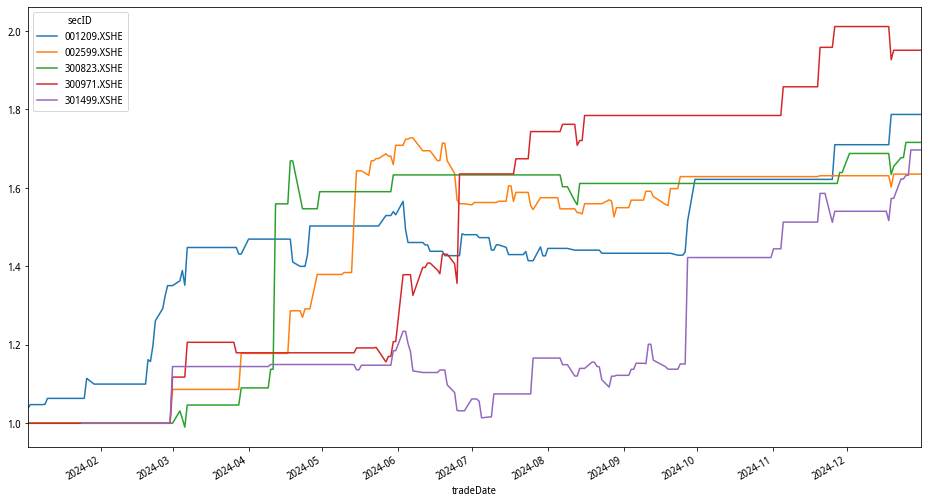

In [173]:
ret_df_2023.loc[ret_df_2024['secID'].isin(best_sec)].pivot(index='tradeDate',columns='secID',values='cum_rule_ret').plot()

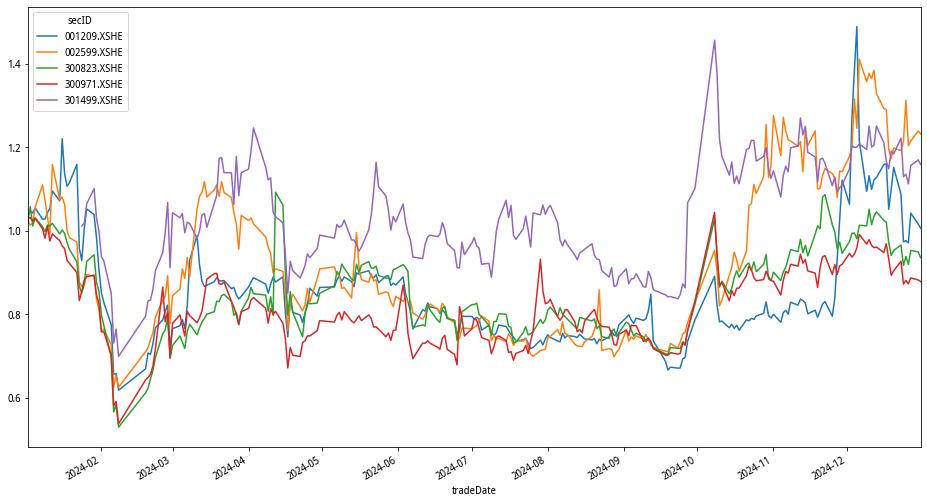

In [174]:
ret_df_2024.loc[ret_df_2024['secID'].isin(best_sec)].pivot(index='tradeDate',columns='secID',values='cum_open_ret').plot()

In [180]:
final_ret_2024.sort_values('cum_rule_ret', inplace=True)
worst_sec = final_ret_2024.loc[final_ret_2024['tradeDate']=='2024-12-31'].index[0:10]

In [181]:
final_ret_2024

tradeDate  open_ret  rule_ret  1+rule_ret  cum_rule_ret  \
secID                                                                  
600766.XSHG 2024-06-26  0.000000       0.0         1.0      0.043896   
002645.XSHE 2024-12-31  0.005715       0.0         1.0      0.480537   
688052.XSHG 2024-12-31  0.028146       0.0         1.0      0.540727   
603900.XSHG 2024-12-31 -0.029472      -0.0         1.0      0.560895   
300578.XSHE 2024-12-31 -0.005373      -0.0         1.0      0.566248   
000793.XSHE 2024-12-31 -0.043963      -0.0         1.0      0.567882   
002696.XSHE 2024-12-31 -0.022430      -0.0         1.0      0.570225   
002205.XSHE 2024-12-31 -0.029884      -0.0         1.0      0.577914   
...                ...       ...       ...         ...           ...   
300643.XSHE 2024-12-31 -0.014293      -0.0         1.0      1.562787   
002815.XSHE 2024-12-31  0.032842       0.0         1.0      1.564701   
301125.XSHE 2024-12-31 -0.017146      -0.0         1.0      1.575877   
002599.XSHE 2024-12-31 -0.006179      -0.0         1.0      1.635174   
301499.XSHE 2024-12-31 -0.009158      -0.0         1.0      1.696653   
300823.XSHE 2024-12-31 -0.014476      -0.0         1.0      1.715913   
001209.XSHE 2024-12-31 -0.009698      -0.0         1.0      1.787191   
300971.XSHE 2024-12-31 -0.004270      -0.0         1.0      1.950768   

             1+open_ret  cum_open_ret  
secID                                  
600766.XSHG    1.000000      0.045075  
002645.XSHE    1.005715      0.656424  
688052.XSHG    1.028146      0.820316  
603900.XSHG    0.970528      0.872279  
300578.XSHE    0.994627      1.174208  
000793.XSHE    0.956037      1.202773  
002696.XSHE    0.977570      0.735804  
002205.XSHE    0.970116      0.820532  
...                 ...           ...  
300643.XSHE    0.985707      1.030512  
002815.XSHE    1.032842      1.207934  
301125.XSHE    0.982854      0.863651  
002599.XSHE    0.993821      1.231473  
301499.XSHE    0.990842      1.158734  
300823.XSHE    0.985524      0.935426  
001209.XSHE    0.990302      1.006124  
300971.XSHE    0.995730      0.878186  

[857 rows x 7 columns]

In [182]:
worst_sec

Index(['002645.XSHE', '688052.XSHG', '603900.XSHG', '300578.XSHE',
       '000793.XSHE', '002696.XSHE', '002205.XSHE', '600448.XSHG',
       '688283.XSHG', '600243.XSHG'],
      dtype='object', name='secID')

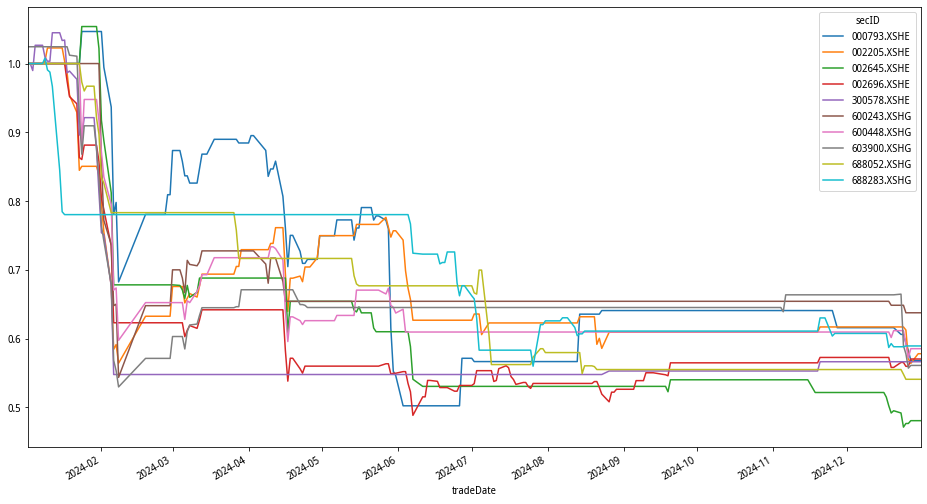

In [183]:
ret_df_2024.loc[ret_df_2024['secID'].isin(worst_sec)].pivot(index='tradeDate',columns='secID',values='cum_rule_ret').plot()

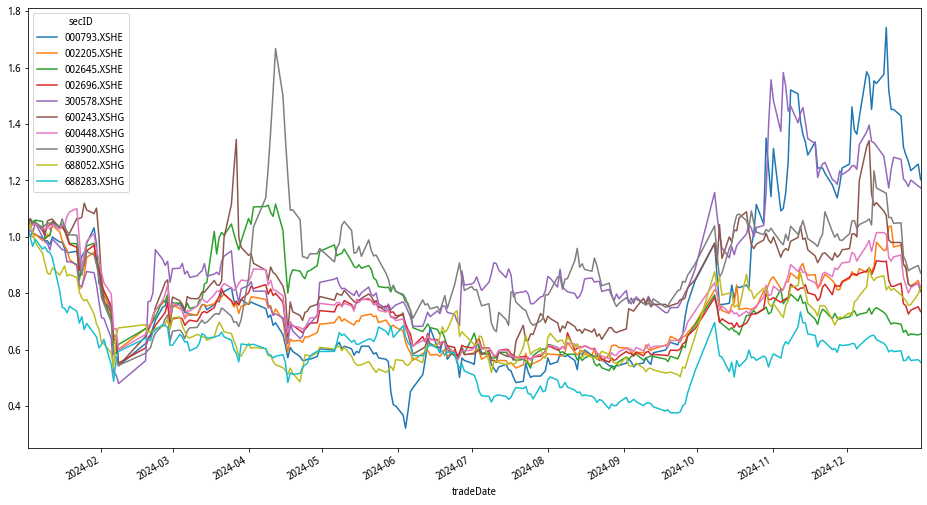

In [184]:
ret_df_2024.loc[ret_df_2024['secID'].isin(worst_sec)].pivot(index='tradeDate',columns='secID',values='cum_open_ret').plot()